$\newcommand{\R}{\mathbf R}$
$\newcommand{\Id}{{\mathrm{Id}}}$

# Practical session, part 2 : diffeomorphic matching

## a) Functions and results from part 1

We resume the situation of section 2 of the first notebook: we define a transformation $\phi=\Id+v$ on $\R^2$ verifying specific constraints $\phi(y_i)=z_i$, and such that $ \|v\|_V$ is minimal, where $V$ is a Hilbert space of kernel vector fields $K_V$. Here is a gathering of functions used in this part :

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def KernelMatrix(x,y,h):
    return h(np.sum((x[:,None,:]-y[None,:,:])**2,axis=2))

def MatchingLinear(y,z,h,l=0):
    a = np.linalg.solve(KernelMatrix(y,y,h)+l*np.eye(y.shape[0]),z-y)
    def phi(x):
        return x+np.dot(KernelMatrix(x,y,h),a)
    return phi

def gauss(sigma) :
    def f(r2) :
        return np.exp(-r2/sigma**2)
    return f

def cauchy(sigma) :
    def f(r2) :
        return 1/(1+r2/sigma**2)
    return f


def MatchingTPS(y,z,l=0):
    # Function similar to MatchingLinear but the method used here
    # is the Thin Plate Splines method (cf TP1, questions 13 and 14)
    # remark: the kernel function h(r)=r^2log(r) is only valid in theory
    # only for data in dimension 2.
    def TPSfun(r2):
        # function h(r2) = r2 log(sqrt(r2))
        r2[r2==0]=1
        return r2 * np.log(np.sqrt(r2))
    h = TPSfun
    n,d = y.shape
    Kyy =  KernelMatrix(y,y,h) + l*np.eye(n)
    yt = np.concatenate((np.ones((n,1)),y),axis=1)
    M1 = np.concatenate((Kyy,yt),axis=1)
    M2 = np.concatenate((yt.T,np.zeros((d+1,d+1))),axis=1)
    M = np.concatenate((M1,M2))  
    c = z-y
    ct = np.concatenate((c,np.zeros((d+1,c.shape[1]))))
    a = np.linalg.solve(M,ct)
    def phi(x):
        Kxy = KernelMatrix(x,y,h)
        nx = x.shape[0]
        xt = np.concatenate((np.ones((nx,1)),x),axis=1)
        N = np.concatenate((Kxy,xt),axis=1)
        return x+np.dot(N,a)
    return phi



# Display functions

def PlotConfig(lmk, pts=None, clr='k', phi=lambda x:x, withgrid=True, title=None):
    # Function for displaying a configuration of points, with or without deformation.
    # arguments:
    # lmk: size array (n,2), reference point coordinates (y_i or z_i)
    # pts: optional, array (N,2), coordinates of additional points.
    # clr: optional, character (eg 'r' or 'b') specifying the color used to display the points.
    # phi: optional, Python function returned by MatchingLinear or similar method,
    # giving the phi transformation. If phi is given, the phi transformation is applied
    # on the lmk and pts points.
    # withgrid: optional, if False, the deformation grid is not displayed.
    # title: optional, figure title
    if type(pts)==type(None):
        pts = lmk
    plt.axis('equal')
    if withgrid:
        # definition of a square grid adapted to the points
        mn, mx = lmk.min(axis=0), lmk.max(axis=0)
        c, sz = (mn+mx)/2, 1.2*(mx-mn).max()
        a, b = c-sz/2, c+sz/2
        ng = 200
        X1, X2 = np.meshgrid(np.linspace(a[0],b[0],ng),np.linspace(a[1],b[1],ng))
        x = np.concatenate((X1.reshape(ng*ng,1),X2.reshape(ng*ng,1)),axis=1)
        x = phi(x)
        X1 = x[:,0].reshape(ng,ng)
        X2 = x[:,1].reshape(ng,ng)
        plt.plot(X1,X2,clr,linewidth=.25)
        plt.plot(X1.T,X2.T,clr,linewidth=.25)
    phipts = phi(pts)
    philmk = phi(lmk)
    plt.plot(phipts[:,0],phipts[:,1],'.'+clr,markersize=.1)
    plt.plot(philmk[:,0],philmk[:,1],'o'+clr)
    if title:
        plt.title(title)

def PlotResMatching(phi, lmk1, lmk2, pts1=None, Q=None, withgrid=True, title=None):
    # Function for displaying the result of a point match.
    # arguments:
    # phi: Python function returned by MatchingLinear or similar method, giving the phi transformation
    # lmk1: size array (n,2), source point coordinates (y_i)
    # lmk2: size array (n,2), target point coordinates (z_i)
    # pts1: optional, array (N,2), coordinates of additional points representing the source shape/image
    # Q: optional, table of size (n,2,nt) giving the trajectories of the reference points (for part 1)
    # withgrid: optional, if False, the deformation grid is not displayed
    # title: optional, figure title    PlotConfig(lmk1, withgrid=False, clr='b')
    PlotConfig(lmk2, withgrid=False, clr='r')
    PlotConfig(lmk1, pts=pts1, phi=phi, clr='k', withgrid=withgrid)
    if Q is None:
        Q = np.concatenate((lmk1[:,:,None], lmk2[:,:,None]), axis=2)
    plt.plot(Q[:,0,:].T,Q[:,1,:].T, 'k');
    plt.plot(Q[:,0,1:-1].T,Q[:,1,1:-1].T, 'k+');
    if title:
        plt.title(title)

    
    

def load(fname='store.pckl'):
    import pickle
    f = open(fname, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

<br>

Here are some results using these functions. First a random configuration:

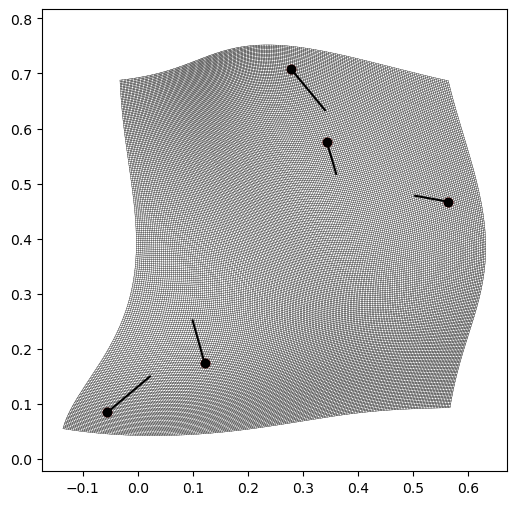

In [3]:
# Example of linear matching with random points
lmk1 = np.random.rand(5,2)
lmk2 = lmk1 + .1 * np.random.randn(5,2)
sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))
plt.rcParams['figure.figsize'] = [6, 6]
PlotResMatching(phi,lmk1,lmk2)

<br>

Then points identified on images of two fishes :

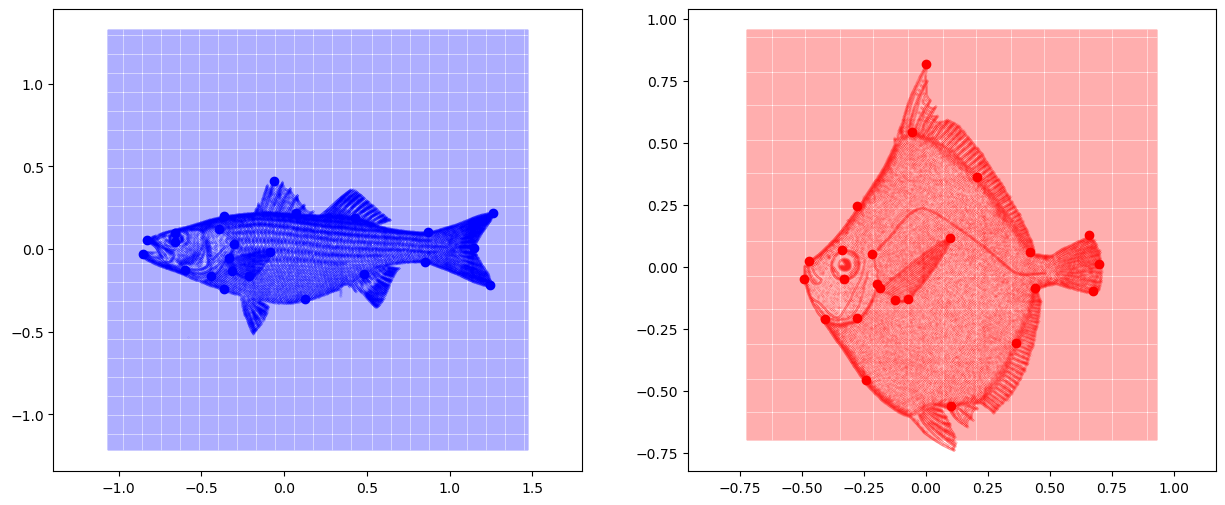

In [5]:
# Loading and displaying "fish" data
pts1,pts2,lmk1,lmk2 = load('fish.pckl')
plt.rcParams['figure.figsize'] = [15, 6]
plt.figure()
plt.subplot(1,2,1)
PlotConfig(lmk1, pts1, clr='b')
plt.subplot(1,2,2)
PlotConfig(lmk2,pts2, clr='r')

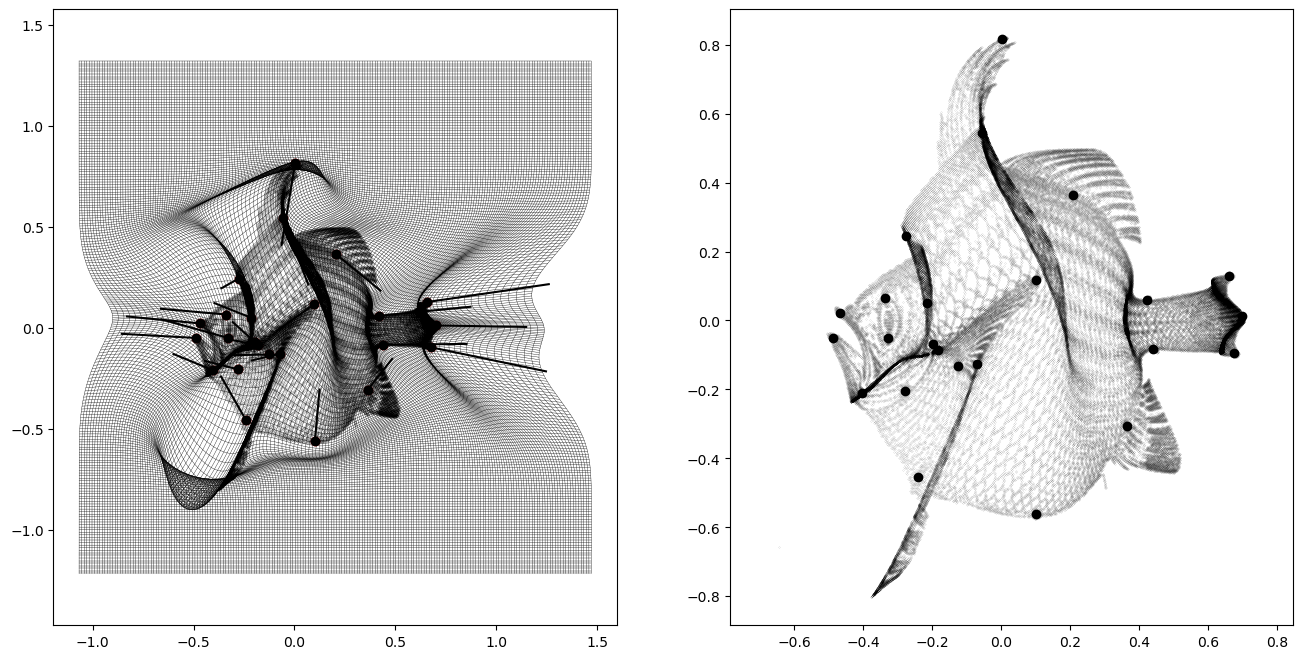

In [6]:
# Linear matching with "fish" data
sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1=pts1)
plt.subplot(1,2,2)
PlotConfig(lmk1,pts1,phi=phi, withgrid=False)

In [ ]:
# Matching by the Thin Plate Splines method
sigma = .25
phi = MatchingTPS(lmk1,lmk2)
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1=pts1)
plt.subplot(1,2,2)
PlotConfig(lmk1,pts1,phi=phi, withgrid=False)

$\newcommand{\id}{{\mathrm{id}}\,}$

## b. From linear matching to diffeomorphisms

We will see how
the composition of small deformations makes it possible to solve the problem of non-invertibility of the linear approach.
For this we take the situation of section 2 of the first practical work, but instead of carrying out the pairing of the $y_i$ towards the $z_i$ in a single step, we introduce intermediate points
$y_i=q_i^1,q_i^2,\cdots,q_i^{n_t}=z_i$ regularly spaced along the segment $[y_i,z_i]$ and we calculate the linear matching of $q_i^t$ towards the $q_i^{t+1}$, successively for $1\leq t\leq n_t-1$. We then simply compose the deformations $\phi^t=\id+v^t$ obtained: $\phi:=\phi^{n_t-1}\circ\cdots\circ\phi^1$.

Here is a function to calculate intermediate points along segments $[y_i,z_i]$:

In [7]:
def LinTraj(y,z,nt=10):
    # returns Q array of size (n,d,nt) giving point coordinates
    # q_i^t of R^d regularly spaces along the segments [y_i,z_i]
    # arguments:
    # y: array (n,d), coordinates of points y_i
    # z: array (n,d), coordinates of the points z_i
    # nt: number of points along the segment (including endpoints)
    Q = np.dot(y[:,:,None],np.linspace(1,0,nt)[None,:]) + np.dot(z[:,:,None],np.linspace(0,1,nt)[None,:])
    return Q

<br>

We test the proposed approach on an example where linear matching results in a non-invertible $\phi$ deformation ("folded" deformation grid).

In [8]:
def MatchingSteps(Q,h):
    # pairing of points labeled by linear pairing composition
    # Q is an array of size (n,d,nt) giving the coordinates of the points
    # q_i^t of R^d, for 1 <= i <= n and 1 <= t <= nt
    tabphi = {}
    nt = Q.shape[2]
    for t in range(nt-1):
        tabphi[t] = MatchingLinear(Q[:,:,t],Q[:,:,t+1],h)
    def phi(x):
        for t in range(nt-1):
            x = tabphi[t](x)
        return x
    return phi

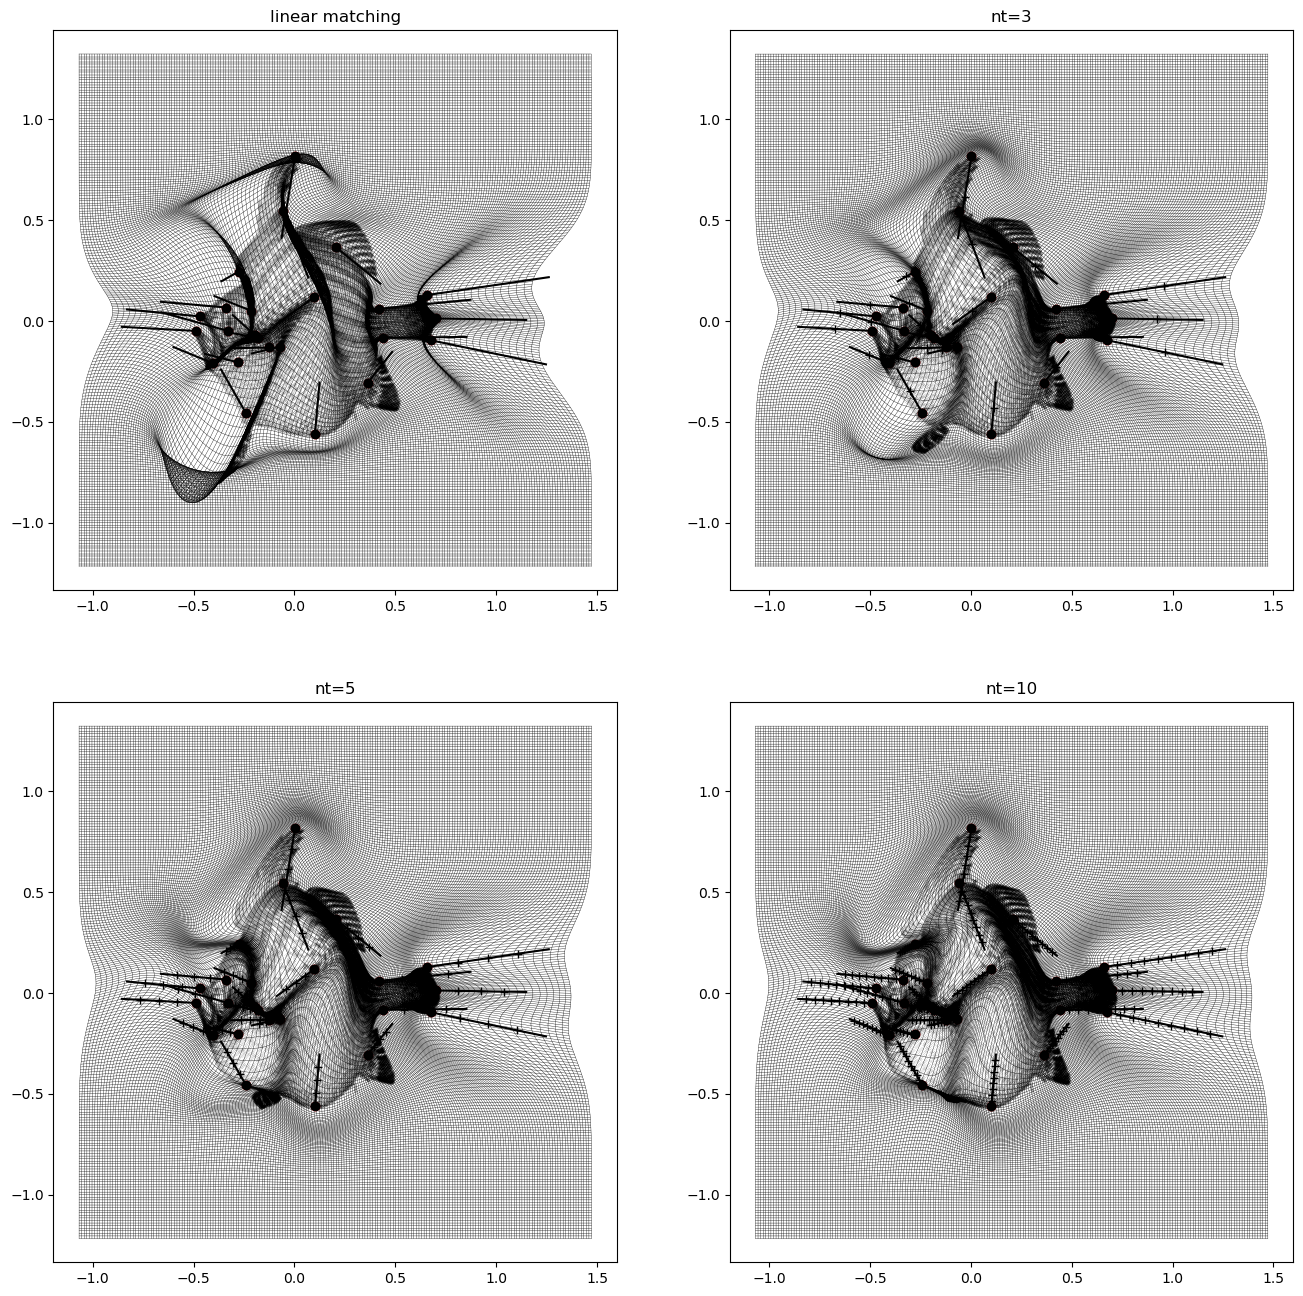

In [9]:
# test with "fish" data
pts1,pts2,lmk1,lmk2 = load('fish.pckl')

sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))

plt.rcParams['figure.figsize'] = [16, 16]
plt.subplot(2,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1, title="linear matching")

Q = LinTraj(lmk1, lmk2, nt=3)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,2)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=3")

Q = LinTraj(lmk1, lmk2, nt=5)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,3)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=5")

Q = LinTraj(lmk1, lmk2, nt=10)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,4)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=10")

$\def\scal#1#2{\left\langle #1\mathbin{,}#2\right\rangle}$
$\renewcommand{\i}{^{-1}}$

The positions of the intermediate points $q_i^t$, $2\leq t\leq n_t-1$ are in fact free and one can seek to optimize these positions by minimizing the following energy
$$J(q^2,\ldots,q^{n_t-1}):=\sum_{t=1}^{n_t-1}\scal{q^{t+1}-q^t}{ K(q^t)\i(q^{t+1}-q^t)}.$$

To avoid the tedious calculation of the gradient of this functional, we will use the PyTorch autodifferentiation module.

<br>

Here is a function `Energy(Q,h)`
which returns the value of the functional. The $Q$ input is assumed to be of type `torch.tensor`, and the $h$ function as well as the `KernelMatrix` function must be rewritten with PyTorch syntax, such that the function can be differentiated.

In [22]:
import torch 
from torch.autograd import grad

def gauss2_torch(sigma):
    # PyTorch version of the gauss function
    def f(u) :
        return torch.exp(-u/sigma**2)
    return f
  
def KernelMatrix_torch(x,y,h):
    # rewrite of KernelMatrix to use PyTorch instead of NumPy
    return h(torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))
    
def Energy(Q,h):
    # computation of function J
    # Q is an array of size (n,d,nt) of type torch.tensor
    # h is a scalar function
    nt = Q.shape[2]
    J = 0
    for t in range(nt-1):
        K = KernelMatrix_torch(Q[:,:,t],Q[:,:,t],h)
        dQ = Q[:,:,t+1]-Q[:,:,t]
        J += torch.sum(dQ*(torch.inverse(K)@dQ))
    return J

# testing automatic differentiation
lmk1 = np.random.rand(5,2)
lmk2 = lmk1 + .1 * np.random.randn(5,2)
sigma = .25
Q = LinTraj(lmk1,lmk2,nt=10)
Q = torch.tensor(Q, requires_grad=True)
h = gauss2_torch(sigma)
gradE = grad(Energy(Q,h),Q)[0]
print("gradE = ",gradE)

gradE =  tensor([[[-2.6170e-01,  4.5836e-02,  3.0147e-02,  2.0099e-02,  1.3224e-02,
           8.1649e-03,  4.0973e-03,  3.9989e-04, -3.5580e-03,  7.3756e-02],
         [-1.0684e-01, -1.3175e-02, -6.7567e-03, -2.9278e-03, -5.4680e-04,
           1.0920e-03,  2.4908e-03,  4.0405e-03,  6.1060e-03, -4.2572e-02]],

        [[-4.1849e-02, -2.7999e-03, -1.5545e-03, -8.2014e-04, -5.3874e-05,
           9.1082e-04,  2.0301e-03,  3.2542e-03,  4.6695e-03,  1.5514e-02],
         [ 5.8973e-03, -1.4721e-03, -1.0516e-03, -1.3739e-03, -2.2754e-03,
          -3.4853e-03, -4.7696e-03, -6.0635e-03, -7.5260e-03,  5.4163e-03]],

        [[ 2.8017e-01, -4.7773e-02, -3.2964e-02, -2.3355e-02, -1.6841e-02,
          -1.2307e-02, -9.0870e-03, -6.7332e-03, -4.9483e-03, -5.1862e-02],
         [ 1.4005e-01,  1.6150e-02,  8.9743e-03,  4.8129e-03,  2.6090e-03,
           1.6224e-03,  1.2659e-03,  1.1349e-03,  1.0240e-03, -1.9654e-02]],

        [[-7.2850e-03,  5.9929e-03,  5.9128e-03,  5.2704e-03,  4.1363e-03,
    

$ $
$ $

Here is a fixed-step gradient descent on the previous functional, with $n_t=5$. We test first for configurations of 5 randomly drawn points, then for the fish example.

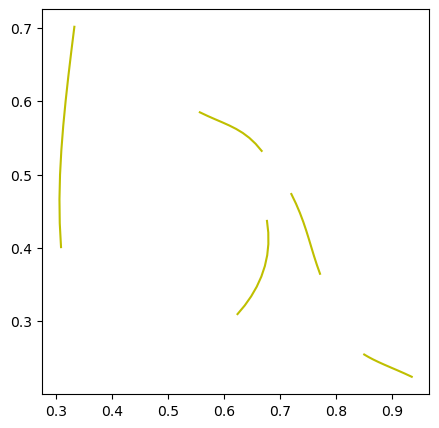

In [24]:
# gradient descent

Niter = 2000
nt = Q.shape[2]
eta = 0.01
for i in range(Niter):
    J = Energy(Q,h)
    GJ = grad(J,Q)[0]
    Q[:,:,1:nt-1].data -= eta*GJ[:,:,1:nt-1].data

# function for displaying q_i^t trajectories
def PlotTrajs(Q):
    plt.plot(Q[:,0,:].T,Q[:,1,:].T,'y');

plt.rcParams['figure.figsize'] = [5, 5]
PlotTrajs(Q.detach().numpy())

$\renewenvironment{acc}{\begin{array}{l}}{\end{array}}$
$\renewcommand{\bacc}{\begin{acc}}$
$\renewcommand{\eacc}{\end{acc}}$

The previous model
constitutes in fact a first implementation of the diffeomorphic approach which defines the deformations $\phi$ by integration of a family of vector fields
$(v(t,\cdot))_{t\in[0,1]}$ in $V$:
$$\bacc \phi:=\phi(1,\cdot),\\\frac{\partial\phi}{\partial t}(t,x)=v(t,\phi(t,x)) ,\eacc$$
and consider the following matching problem:
$$(P) \quad \text{Minimize}\quad J(v)=\int_0^1\|v(t,\cdot)\|_V^2dt\quad\text{under constraints}\quad\phi ^v(1,y_i)=z_i,\;\; 1\leq i\leq n.$$

<br>
<br>
<br>

## c. Hamiltonian approach and geodesic equations.

$\newcommand{\be}{\begin{eqnarray*}}
\newcommand{\ee}{\end{eqnarray*}}
\newcommand{\Norm}[2]{\|#2\|_{#1}}
\newcommand{\qu}{\quad}
\newcommand{\Scal}[3]{\langle#2,#3\rangle_{#1}}
\newcommand{\beq}{\begin{eqnarray}}
\newcommand{\eeq}{\end{eqnarray}}
$

Geodesic equations can be written via a Hamiltonian formulation. For any trajectory $q(t)$, we set (omitting the dependence on $t$ to simplify the
writings):
- $L(q,\dot q)=\frac12\Norm{q}{\dot q}^2\qu$ (Lagrangian),
- $p=\nabla_{\dot q}L(q,\dot q)\qu$ (gradient of $L$ with respect to $\dot q$ for the Euclidean metric),
- $H(p,q)=\Scal{\R^{2n}}{p}{\dot q}-L(q,\dot q)\qu$ (Hamiltonian)

We then show that the geodesic trajectories satisfy
$\beq\label{eq:geod}\bacc \dot p=-\nabla_qH(p,q)\\\dot q=\nabla_pH(p,q).\eacc\eeq\qu$ (1)

<br>

Below is a full implentation of LDDMM for landmarks. We write a `Hamilt(p,q,h)` function to calculate $H(p,q)$, then a `HamiltSys(p,q,h)` function to calculate $(\dot p,\dot q )$ from equations (1), and using automatic differentiation. Then we write a function
`Shooting(p0,q0,h)`
which, starting from an initial configuration $p(0), q(0)$, solves equation (1) numerically by a simple Euler scheme, then returns $p(1)$, $q(1)$ as well as $Q$ containing all the trajectories.
We test this function for the previous configurations by choosing random moment vectors $p(0)$, then display the obtained trajectories and the deformation of a regular grid.

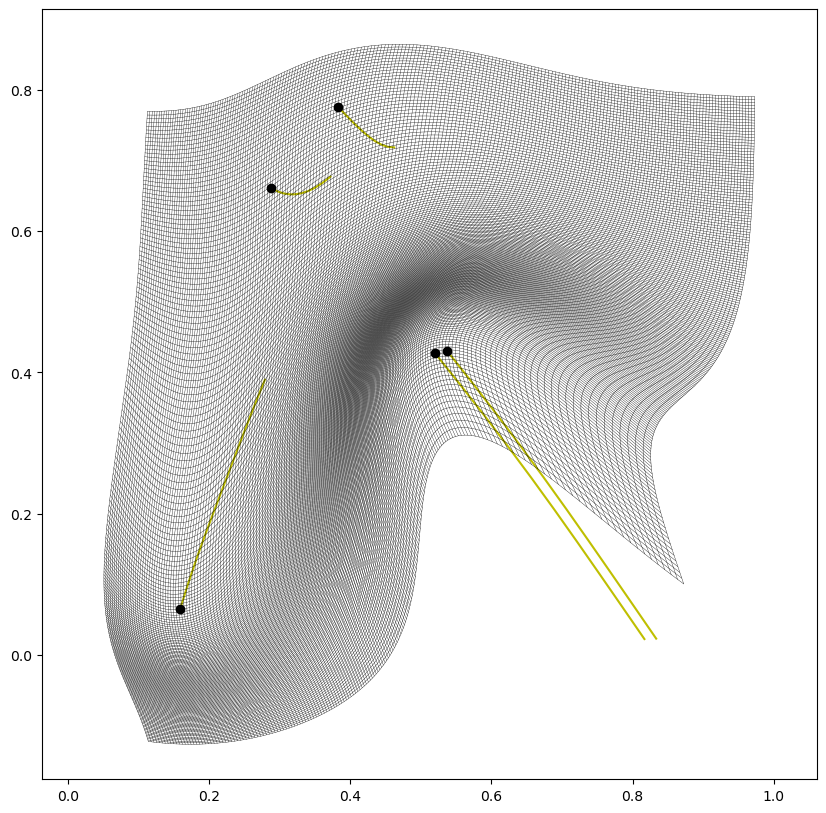

In [18]:
def Hamilt(p,q,h):
    K = KernelMatrix_torch(q,q,h)
    return torch.sum(p*(K@p))

def HamiltSys(p,q,h):
    gH = grad(Hamilt(p,q,h),[p,q],create_graph=True)
    return -gH[1], gH[0]

def Shooting(p0,q0,h,nt=10):
    n, d = q0.shape
    Q = np.zeros((n,d,nt))
    Q[:,:,0] = q0.detach().numpy()
    p, q = p0.clone(), q0.clone()
    dt = 1/(nt-1)
    for t in range(nt-1):
        pdot, qdot = HamiltSys(p,q,h)
        p = p + dt * pdot
        q = q + dt * qdot
        Q[:,:,t+1] = q.detach().numpy()
    return p, q, Q

q0 = torch.tensor(lmk1,dtype=torch.float32,requires_grad=True)
p0 = .1*torch.randn(5,2,requires_grad=True)
sigma = .25
h = gauss2_torch(sigma)
_, _, Q = Shooting(p0,q0,h,nt=10)
plt.rcParams['figure.figsize'] = [10, 10]
PlotTrajs(Q)
phi = MatchingSteps(Q,gauss(sigma))
PlotConfig(q0.detach().numpy(), phi=phi)

<br>

Finally we
write a function `loss(p0,q0,z,h)` returning the sum of the squares of the distances from $q_i(1)$ to $z_i$, and perform a simple gradient descent on this function in order to optimize on the initial moments. We display the trajectories $q_i(t)$ and the diffeomorphic matching obtained.

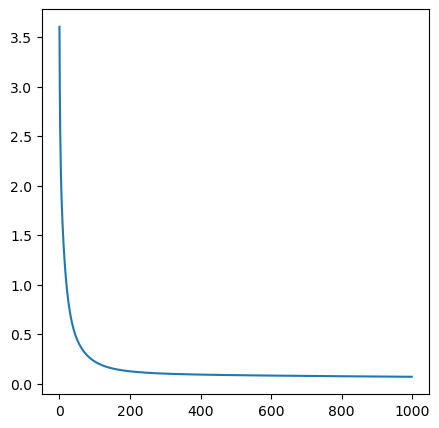

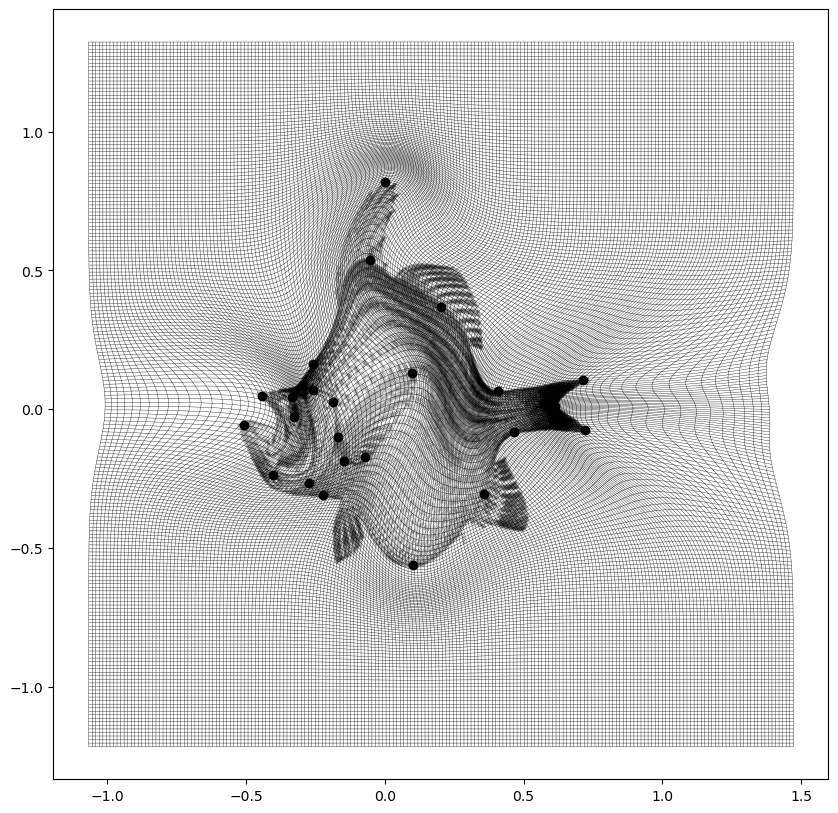

In [25]:
def loss(p0, q0, z, h):
    _, q1, _ = Shooting(p0,q0,h)
    return torch.sum((q1-z)**2)

pts1,pts2,lmk1,lmk2 = load('fish.pckl')

N = 1000
rec_loss = np.zeros(N)
eta = 0.001
q0 = torch.tensor(lmk1,dtype=torch.float32,requires_grad=True)
p0 = .1*torch.randn(q0.shape,requires_grad=True)
z = torch.tensor(lmk2, dtype=torch.float32)
for k in range(N):
    l = loss(p0, q0, z, h)
    rec_loss[k] = l.detach().numpy()
    gl = grad(l,p0)[0]
    p0.data -= eta * gl

plt.plot(rec_loss)
plt.show()
_, _, Q = Shooting(p0,q0,h,nt=10)
#PlotTrajs(Q)
phi = MatchingSteps(Q,gauss(sigma))
plt.rcParams['figure.figsize'] = [10, 10]
PlotConfig(lmk1,pts1,phi=phi)
plt.show()